In [1]:
import os
import sys
import pandas as pd

import numpy as np
from numpy import exp
from numpy import log
from numpy import sqrt
from numpy import power

import scipy
from scipy import special

import math
from math import pi
from math import erf
from math import erfc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
os.getcwd()

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/UOWC")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/UOWC'

In [3]:
class Watertype:
  """
Define the water type and caharacteristics
  Attributes:
    channel_loss:channel loss diffuse coefficient
    Turbulence:
  """
  def __init__(self,channel_loss,Turbulence):
    self.channel_loss = channel_loss
    self.Turbulence = Turbulence
    self.name = ""

In [4]:
# Genarate data with constant noise
def Simulated_dataset(SNR,Z,P,Watertype,Noise='Gauss'):
  """
  This function is used to simulate the input signal to demudulator.
  Args:
    SNR: signl to noise ratios
    Z: channel lenth
    P: transmission power
    Noise:

  Returns:S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal
   the function returns: numrical signal of bit 1 bit 0 , standard divation of bit 1 noise ,bit 0 noise,optimal Threshold

  """
  ######## Receiver SiPM ::MICROFC−SMTPA−30035
  PDE = 0.31 #photo detection efficiency 3mm Sensor 35um - 30035, overvoltage @ 2.5V
  lamda = 420e-9 #Wavelength of Blue light
  A = 0.0058  #SiPM surface area
  G = 3e6#Gain
  pap = 0.002 #probability of afterpulsing
  dCR = 300 #dark count rate6.6*10^6
  Nspad = 4774 #  number of SPAD (microcells)
  td = 82e-9  #  tau_d deadtimex
  P_AP = 1+pap #  probability of current
  pxt = 0.07 # probability of crosstalk
  P_XT = 1 + 0.07 #excess noise factor
  Fe=1.1  # funtion of the doping profile
  RL = 10 #load resistance
  F = P_XT
  ##### constant
  c = 2.25e8 #light speed
  hp = 6.626e-34  # Planck's constant h,
  K_Z = 1.380649e-23 #Boltzmann constant,
  e = 1.6e-19  # Charge of Electron
  Res=PDE*lamda*G*e*P_AP*P_XT/(hp*c)  # SiPM responsitivity
  #  Laser Diode Parameters
  ext=0.33 # extinction ratio
  Ptx1 =(1-ext)*P  #[0.25,0.40,0.5] #  power of bit 1 in watt
  Ptx0=ext*P    # 0.0008   wpower of bit 0 in watt
  ###water characteristics
  ce = Watertype.channel_loss ##channel loss diffuse coefficient
  Lch=math.exp(-ce*Z) # channel loss
  h_L=Lch # channel loss factor

  ### Signal dataset infromation
  Rb = 10e6#[10,30,60]e6 #transmitt data rate
  B=Rb/2 # receiver low-pass filter Bandwidth
  lenth=int(1e6)#  length of the signal and noise
#####total channel gain
  h_gain = h_L #*h_P#*h_T without turbulence without pointing error
#######    noise  ######
  # sgma2_t_n0  = Ptx0/power(10,SNR/10) #variance of the total signal noise for bit 1
  # sgma2_t_n1  = Ptx1/power(10,SNR/10) #variance of the total signal noise for bit 0

  T=300 # equivqlent noise temperature [K]
  Is_1msm1=Res*Ptx1*RL
  Is_0msm0=Res*Ptx0*RL

  I_D = e*G*dCR*(1+pap+pxt)
  sgma2_T = 4*K_Z*T*B*RL
  sgma2_D = 2*e*G*F*B*I_D
  sgma2_s_0 = 2*e*G*F*B*Is_0msm0
  sgma2_s_1 = 2*e*G*F*B*Is_1msm1
  sgma2_t_n0 = sgma2_T +(sgma2_D + sgma2_s_0*h_gain)*(RL**2)
  sgma2_t_n1 = sgma2_T +(sgma2_D + sgma2_s_1*h_gain*1)*(RL**2)
  # print('sgma2_t_n0',sgma2_t_n0,'sgma2_t_n1',sgma2_t_n0)
  #the noise of bit 1 0
  if Noise == "Gauss":
    Noise_0 = np.random.normal(0, np.sqrt(sgma2_s_0*h_gain), lenth)
    Noise_1 = np.random.normal(0, np.sqrt(sgma2_s_1*h_gain), lenth)
  # the noise is Rayleigh noise
  elif Noise == "Rayleigh":
    Noise_0 = np.random.rayleigh(np.sqrt(sgma2_t_n0), lenth)
    Noise_1 = np.random.rayleigh(np.sqrt(sgma2_t_n1), lenth)
  elif Noise == "Uniform":
    Noise_0 = np.random.uniform(-sqrt(sgma2_t_n0),+sqrt(sgma2_s_0),lenth)
    Noise_1 = np.random.uniform(-sqrt(sgma2_t_n1),+sqrt(sgma2_s_1),lenth)
  else:
    print("Please choose noise type: Gauss, Rayleigh, Uniform")
    sys.exit()
####The optical signal received by the SiPM after underwater propagation
  S_R0 = Res*h_gain*Ptx0 + Noise_0 + I_D
  S_R1 = Res*h_gain*Ptx1 + Noise_1 + I_D
####the input signals to the demodulator corresponding to “0” and “1” bits,
  S_0 = RL*S_R0*1e-3 # nurmical simulated current of bit 1
  S_1 = RL*S_R1*1e-3 # nurmical simulated current of bit 0
#
  Denm_trm1 = sqrt(sgma2_t_n1) # standard deviation of bit 1
  Denm_trm0 = sqrt(sgma2_t_n0) # standard deviation of bit 0
#### Here calculate the optimal threshold
  Threshold_optimal = (S_0*sgma2_t_n1  - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ) + ((S_1**2*sgma2_t_n0 )/(sgma2_t_n1 - sgma2_t_n0 ) + ((S_0*sgma2_t_n1
    - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ))**2 - (S_0**2*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 )
     - ((sgma2_t_n0*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 ))*log(sgma2_t_n0 /sgma2_t_n1 ))**0.5
  return S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal


In [ ]:
# Define the parameters
SNR = 30
Z = 7
P = 0.25
clearwater = Watertype(0.551,0)
clearwater.channel_loss

0.551

In [ ]:
S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal = Simulated_dataset(SNR,Z,P,clearwater,Noise='Gauss')
Label0 = np.zeros(len(S_0))
Label1 = np.ones(len(S_1))

In [ ]:
# File path
file_path = 'supervised_dataset.csv'
# Check if the file exists and delete it if it does
if os.path.exists(file_path):
    os.remove(file_path)
# Create a DataFrame
data1 = pd.DataFrame({'Feature': S_1, 'Label': Label1})
data0 = pd.DataFrame({'Feature': S_0, 'Label': Label0})
# combine the bit 1 and bit 0 signal
merged_data = pd.concat([data1, data0], ignore_index=True)
# Save the dataset to a CSV file
merged_data.to_csv(file_path, index=False)
# Display the first few rows of the dataset
merged_data.head()
#shuffled_data = shuffle(merged_data)

,Feature,Label
0,15.910476,1.0
1,15.908408,1.0
2,15.907871,1.0
3,15.909366,1.0
4,15.909679,1.0


In [ ]:
shuffled_data = shuffle(merged_data)
shuffled_data

,Feature,Label
907262,15.908737,1.0
1736659,7.833931,0.0
1328707,7.837445,0.0
1104899,7.836124,0.0
1528712,7.835551,0.0
...,...,...
591088,15.905544,1.0
335718,15.908281,1.0
1982317,7.832363,0.0
151231,15.902050,1.0


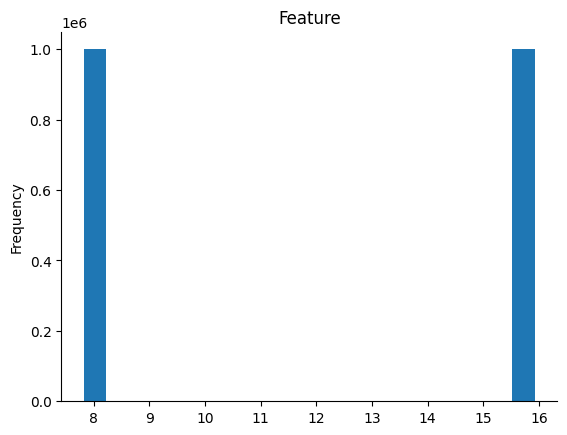

In [ ]:
# plot data features
shuffled_data['Feature'].plot(kind='hist', bins=20, title='Feature')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
shuffled_data['Feature'].plot(kind='hist', bins=20, title='Feature')
plt.gca().spines[['top', 'right',]].set_visible(False)

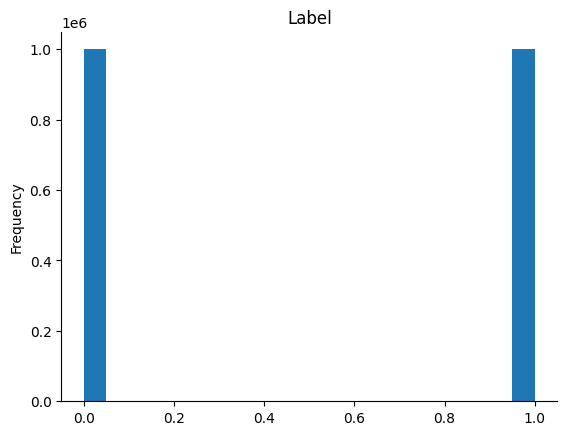

In [ ]:
# plot label features
shuffled_data['Label'].plot(kind='hist', bins=20, title='Label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

In [8]:
# Load the dataset
file_path = 'supervised_dataset.csv'
data = pd.read_csv(file_path)
shuffled_data = shuffle(data)
# Split the dataset into features (X) and labels (y)
X = shuffled_data[['Feature']]
Y = shuffled_data['Label']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
shuffled_data

,Feature,Label
830217,15.904484,1.0
1305819,7.833177,0.0
69640,15.902448,1.0
1699303,7.837243,0.0
298454,15.905480,1.0
...,...,...
1380995,7.833944,0.0
1287964,7.835531,0.0
1952121,7.835126,0.0
1659256,7.838737,0.0


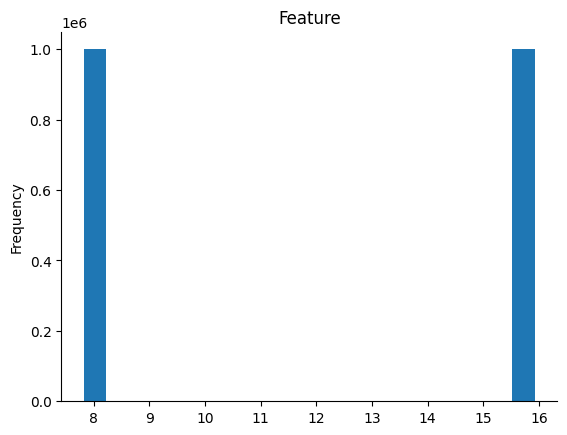

In [9]:
# plot data features
shuffled_data['Feature'].plot(kind='hist', bins=20, title='Feature')
plt.gca().spines[['top', 'right',]].set_visible(False)